
#  Árvore de Decisão — Consumo de Cerveja



In [2]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
)
import matplotlib.pyplot as plt

RANDOM_STATE = 42


In [ ]:
dados = pd.read_csv('consumo_cerveja.csv', decimal=",")

print(dados.shape)
dados.head(5)

(365, 7)


,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,01/01/2015,27.30,23.9,32.5,0.0,0,25.461
1,02/01/2015,27.02,24.5,33.5,0.0,0,28.972
2,03/01/2015,24.82,22.4,29.9,0.0,1,30.814
3,04/01/2015,23.98,21.5,28.6,1.2,1,29.799
4,05/01/2015,23.82,21.0,28.3,0.0,0,28.900


In [4]:

def pick_guess(cols, patterns):
    for pat in patterns:
        for c in cols:
            if pat in c.lower():
                return c
    return None

cols_lower = [c.lower() for c in dados.columns]

CONSUMO_COL = pick_guess(cols_lower, ["consumo", "beer", "litro", "consumption"])
DATE_COL    = pick_guess(cols_lower, ["data", "date"])

# Mapear de volta para o nome original com o mesmo case
if CONSUMO_COL is None:
    raise ValueError(f"Não achei coluna de consumo. Colunas: {list(dados.columns)}")
for c in dados.columns:
    if c.lower() == CONSUMO_COL:
        CONSUMO_COL = c
    if DATE_COL and c.lower() == DATE_COL:
        DATE_COL = c

print("Coluna de consumo:", CONSUMO_COL)
print("Coluna de data:", DATE_COL)

# Parse de data e features de calendário (se houver data)
if DATE_COL:
    dados[DATE_COL] = pd.to_datetime(dados[DATE_COL], dayfirst=True, errors="coerce")
    dados["mes"] = dados[DATE_COL].dt.month
    dados["dia_semana"] = dados[DATE_COL].dt.dayofweek  # 0=segunda ... 6=domingo
    dados["fim_semana_auto"] = (dados["dia_semana"] >= 5).astype(int)

# Normalização de possíveis flags booleanas (fim de semana, feriado, etc.)
for cand in ["fim_de_semana", "final_de_semana", "weekend", "fds", "is_weekend", "feriado", "holiday"]:
    for col in dados.columns:
        if col.lower() == cand:
            norm = (
                dados[col].astype(str).str.strip().str.lower()
                .map({"1":1,"0":0,"true":1,"false":0,"sim":1,"nao":0,"não":0})
            )
            # Se converteu algo, substitui mantendo NaN para valores não mapeados
            if norm.notna().any():
                dados[col] = norm
                # Se a coluna ficou só 0/1, força int
                if dados[col].dropna().isin([0,1]).all():
                    dados[col] = dados[col].astype("Int64").astype(float).astype("Int64").astype(int)

dados.info()


Coluna de consumo: Consumo de cerveja (litros)
Coluna de data: Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Data                         365 non-null    datetime64[ns]
 1   Temperatura Media (C)        365 non-null    float64       
 2   Temperatura Minima (C)       365 non-null    float64       
 3   Temperatura Maxima (C)       365 non-null    float64       
 4   Precipitacao (mm)            365 non-null    float64       
 5   Final de Semana              365 non-null    int64         
 6   Consumo de cerveja (litros)  365 non-null    float64       
 7   mes                          365 non-null    int32         
 8   dia_semana                   365 non-null    int32         
 9   fim_semana_auto              365 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int32(2)

## 3) Alvo binário: consumo **alto** vs **baixo**

In [5]:

# Usamos a mediana para balancear naturalmente as classes
y_threshold = dados[CONSUMO_COL].median()
print("Threshold (mediana):", y_threshold)

dados["consumo_alto"] = (dados[CONSUMO_COL] >= y_threshold).astype(int)
print("Distribuição das classes (0=baixo, 1=alto):")
display(dados["consumo_alto"].value_counts(normalize=True).rename("proporção").round(3))


Threshold (mediana): 24.867
Distribuição das classes (0=baixo, 1=alto):


consumo_alto
1    0.501
0    0.499
Name: proporção, dtype: float64

## 4) Seleção de atributos (X) e alvo (y)

In [6]:

drop_cols = [CONSUMO_COL, "consumo_alto"]
if DATE_COL:
    drop_cols.append(DATE_COL)

X = dados.drop(columns=[c for c in drop_cols if c in dados.columns])
y = dados["consumo_alto"].copy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)


Numéricas: ['Temperatura Media (C)', 'Temperatura Minima (C)', 'Temperatura Maxima (C)', 'Precipitacao (mm)', 'Final de Semana', 'mes', 'dia_semana', 'fim_semana_auto']
Categóricas: []


## 5) Divisão treino/teste (estratificada)

In [7]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((292, 8), (73, 8), 0.5, 0.5068493150684932)

## 6) Pipeline: pré-processamento + Árvore de Decisão (balanceada)

In [8]:

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pre = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols)
    ]
)

tree = DecisionTreeClassifier(
    criterion="entropy",
    class_weight="balanced",   # balanceamento direto
    max_depth=6,
    min_samples_leaf=50,
    random_state=RANDOM_STATE
)

model = Pipeline(steps=[("pre", pre), ("tree", tree)])
model.fit(X_train, y_train)
print("Modelo treinado com class_weight='balanced'.")


Modelo treinado com class_weight='balanced'.


## 7) Avaliação: acurácia, outras métricas e matriz de confusão

Acurácia:  0.753
Precisão:  0.788
Recall:    0.703
F1-Score:  0.743
ROC-AUC:   0.866

Relatório de Classificação:
              precision    recall  f1-score   support

           0      0.725     0.806     0.763        36
           1      0.788     0.703     0.743        37

    accuracy                          0.753        73
   macro avg      0.756     0.754     0.753        73
weighted avg      0.757     0.753     0.753        73



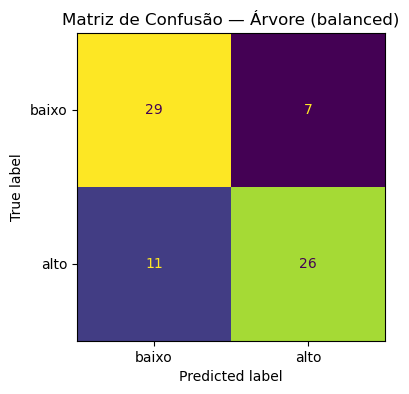

In [9]:

pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred, zero_division=0)
rec = recall_score(y_test, pred, zero_division=0)
f1  = f1_score(y_test, pred, zero_division=0)
auc = roc_auc_score(y_test, proba)

print(f"Acurácia:  {acc:.3f}")
print(f"Precisão:  {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-Score:  {f1:.3f}")
print(f"ROC-AUC:   {auc:.3f}\n")

print("Relatório de Classificação:")
print(classification_report(y_test, pred, digits=3))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["baixo","alto"])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, values_format="d", colorbar=False)
plt.title("Matriz de Confusão — Árvore (balanced)")
plt.show()


## 8) Importância das variáveis

In [10]:

# Recuperar nomes expandidos das variáveis após One-Hot
ohe = None
if len(cat_cols) > 0:
    ohe = model.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]

num_feats = num_cols
cat_feats = ohe.get_feature_names_out(cat_cols).tolist() if ohe is not None else []
all_feats = num_feats + cat_feats

importances = model.named_steps["tree"].feature_importances_
imp = pd.Series(importances, index=all_feats).sort_values(ascending=False)
display(imp.head(15).rename("importância"))


Temperatura Maxima (C)    0.726683
dia_semana                0.273317
Temperatura Media (C)     0.000000
Temperatura Minima (C)    0.000000
Precipitacao (mm)         0.000000
Final de Semana           0.000000
mes                       0.000000
fim_semana_auto           0.000000
Name: importância, dtype: float64

## 9) Regras da Árvore (legíveis)

In [11]:

rules_text = export_text(
    model.named_steps["tree"],
    feature_names=all_feats,
    decimals=2,
    show_weights=True
)
print(rules_text)

# Para salvar localmente:
# with open("regras_arvore.txt", "w", encoding="utf-8") as f:
#     f.write(rules_text)


|--- Temperatura Maxima (C) <= 27.25
|   |--- dia_semana <= 3.50
|   |   |--- weights: [81.00, 8.00] class: 0
|   |--- dia_semana >  3.50
|   |   |--- weights: [35.00, 35.00] class: 0
|--- Temperatura Maxima (C) >  27.25
|   |--- Temperatura Maxima (C) <= 30.55
|   |   |--- weights: [27.00, 55.00] class: 1
|   |--- Temperatura Maxima (C) >  30.55
|   |   |--- weights: [3.00, 48.00] class: 1



## 10) Visualização da Árvore (topo)

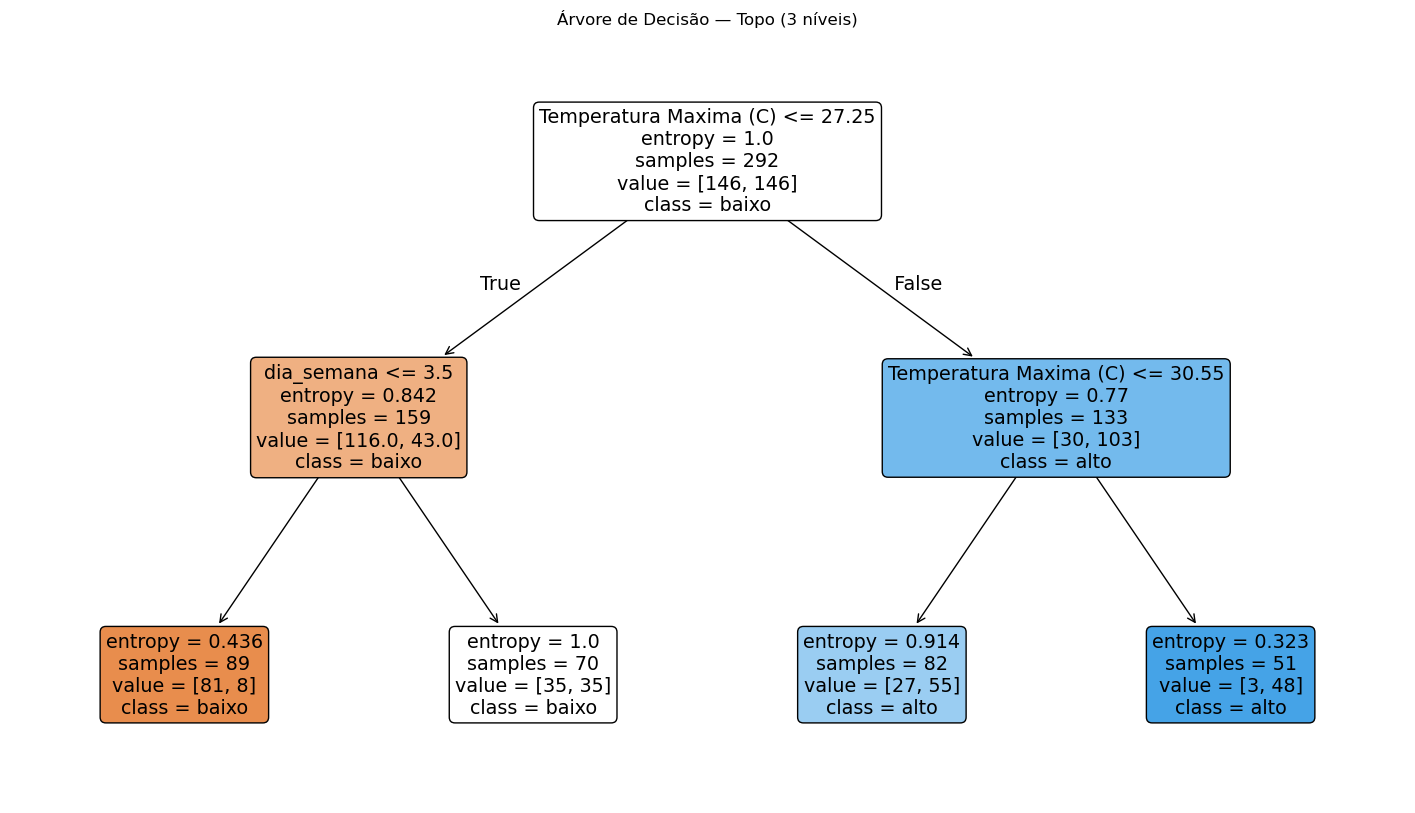

In [12]:

from sklearn import tree as sktree

plt.figure(figsize=(18, 10))
sktree.plot_tree(
    model.named_steps["tree"],
    feature_names=all_feats,
    class_names=["baixo","alto"],
    filled=True,
    rounded=True,
    max_depth=3  # topo para legibilidade
)
plt.title("Árvore de Decisão — Topo (3 níveis)")
plt.show()



## (Opcional) Balanceamento com **SMOTE**
Ative se a classe positiva ficar bem minoritária (por exemplo, usando um quantil mais alto que a mediana).


In [13]:

# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline
# 
# smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
# 
# tree_sm = DecisionTreeClassifier(
#     criterion="entropy",
#     class_weight=None,  # sem 'balanced' quando usar SMOTE
#     max_depth=6,
#     min_samples_leaf=50,
#     random_state=RANDOM_STATE
# )
# 
# model_sm = ImbPipeline(steps=[("pre", pre), ("smote", smote), ("tree", tree_sm)])
# model_sm.fit(X_train, y_train)
# 
# pred_sm = model_sm.predict(X_test)
# proba_sm = model_sm.predict_proba(X_test)[:,1]
# 
# print("=== Árvore + SMOTE ===")
# print("Acurácia:", accuracy_score(y_test, pred_sm).round(3))
# print("Precisão:", precision_score(y_test, pred_sm, zero_division=0).round(3))
# print("Recall:  ", recall_score(y_test, pred_sm, zero_division=0).round(3))
# print("F1:      ", f1_score(y_test, pred_sm, zero_division=0).round(3))
# print("ROC-AUC: ", roc_auc_score(y_test, proba_sm).round(3))
